In [1]:
# Imports
import pandas
import numpy as np

import random
import ast

import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error

# Prepare data

In [2]:
# ?/?/99 -> 1999
# ?/?/10 -> 2010
def GetReleaseYear(orig):
    if pandas.isna(orig):
        return 1900
    yr = int(orig.split('/')[2])
    if yr <= 19:
        return 2000 + yr
    else:
        return 1900 + yr

def GetReleaseDOW(inp):
    import datetime
    if pandas.isna(inp):
        return -1
    month, date, year = map(int, inp.split('/'))
    if year < 20:
        year = 2000 + year
    else:
        year = 1900 + year
    return datetime.datetime(year, month, date).weekday()

K_DATE_RANGES = ['1-5', '6-10', '11-15', 
                 '16-20', '21-25', '26-31']
def GetReleaseDateRange(inp):
    if pandas.isna(inp):
        return 0
    date = int(inp.split('/')[1])
    if date <= 5:
        return '1-5'
    if date <= 10:
        return '6-10'
    if date <= 15:
        return '11-15'
    if date <= 20:
        return '16-20'
    if date <= 25:
        return '21-25'
    return '26-31'

# xx/?/? -> xx
def GetReleaseMonth(orig):
    if pandas.isna(orig):
        return 0
    return int(orig.split('/')[0])
# '{..}' -> {..}
def GetDictionary(s):
    try:
        d = ast.literal_eval(s)
    except ValueError as err:
        if not pandas.isna(s):
            print("get_dictionary error: {}".format(err))
        d = {}    
    return d

def GetCountryCodes(raw):
    return [x.get('iso_3166_1', 'NA').lower() for x in GetDictionary(raw)]

def GetGenres(raw):
    return [x.get('name', 'NA').lower() for x in GetDictionary(raw)]

def GetProductionCompanies(raw):
    return [x.get('name', 'NA').lower().replace(' ', '_')
            for x in GetDictionary(raw)]

# Holder for state needed to convert raw data to 
# sample that can be used for prediction.
class TransformerState:
    def __init__(self):
        pass
    
def TransformAndFix(train, test):
    t_production_countries = train['production_countries'].apply(GetCountryCodes)
    t_genres = train['genres'].apply(GetGenres)    
    t_production_companies = train['production_companies'].apply(GetProductionCompanies)
    ret = TransformerState()
    ret.genres = pandas.Series(t_genres.sum()).value_counts()
    ret.countries = pandas.Series(t_production_countries.sum()).value_counts()
    ret.production_companies = pandas.Series(t_production_companies.sum()).value_counts()
    
    ret.genres = ret.genres[ret.genres > 50]
    ret.countries = ret.countries[ret.countries > 10]
    ret.production_companies = ret.production_companies[ret.production_companies > 10]

    for data in [train, test]:
        data['t_release_yr'] = data['release_date'].apply(GetReleaseYear)
        data['t_release_mo'] = data['release_date'].apply(GetReleaseMonth)
        for comp in ret.production_companies.keys():
            data['t_production_company_{}'.format(comp)] = \
                data['production_companies'].apply(lambda x: comp in GetProductionCompanies(x))

        for g in ret.genres.keys():
            data['t_genre_{}'.format(g)] = \
                data['genres'].apply(lambda x: g in GetGenres(x))
        for c in ret.countries.keys():
            data['t_production_country_{}'.format(c)] = \
                data['production_countries'].apply(lambda x: c in GetCountryCodes(x))
        for dow in range(7):
            data['t_dow_{}'.format(dow)] = \
                data['release_date'].apply(lambda x: dow == GetReleaseDOW(x))
        for date_range in K_DATE_RANGES:
            data['t_date_range_{}'.format(dow)] = \
                data['release_date'].apply(lambda x: date_range == GetReleaseDateRange(x))
    return ret

In [3]:
train_orig = pandas.read_csv('data/train.csv')
test_orig = pandas.read_csv('data/test.csv')

train = train_orig.copy()
test = test_orig.copy()

In [4]:
transformer_state = TransformAndFix(train, test)

In [5]:
cols_to_skip = {'id', 'belongs_to_collection', 'genres', 'homepage',
             'imdb_id', 'original_language', 'original_title', 'overview',
             'production_companies', 'production_countries', 'release_date', 
             'runtime', 'spoken_languages', 'status', 'tagline', 'title', 
             'Keywords', 'cast', 'crew', 'poster_path', 'revenue'}
t_date_range_cols = {c for c in train.columns if c.startswith('t_date_range_')}
useful_columns = [c for c in train.columns if 
                  c not in cols_to_skip 
                    # and c not in t_date_range_cols
                    and c not in {'xgb', 'cat', 'lgb', 'mix1', 'mix2'}]

In [6]:
train[useful_columns].head()

,budget,popularity,t_release_yr,t_release_mo,t_production_company_warner_bros.,t_production_company_universal_pictures,t_production_company_paramount_pictures,t_production_company_twentieth_century_fox_film_corporation,t_production_company_columbia_pictures,t_production_company_metro-goldwyn-mayer_(mgm),...,t_production_country_dk,t_production_country_br,t_dow_0,t_dow_1,t_dow_2,t_dow_3,t_dow_4,t_dow_5,t_dow_6,t_date_range_6
0,14000000,6.575393,2015,2,False,False,True,False,False,True,...,False,False,False,False,False,False,True,False,False,False
1,40000000,8.248895,2004,8,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,3300000,64.299990,2014,10,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,1200000,3.174936,2012,3,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,0,1.148070,2009,2,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [7]:
test[useful_columns].head()

,budget,popularity,t_release_yr,t_release_mo,t_production_company_warner_bros.,t_production_company_universal_pictures,t_production_company_paramount_pictures,t_production_company_twentieth_century_fox_film_corporation,t_production_company_columbia_pictures,t_production_company_metro-goldwyn-mayer_(mgm),...,t_production_country_dk,t_production_country_br,t_dow_0,t_dow_1,t_dow_2,t_dow_3,t_dow_4,t_dow_5,t_dow_6,t_date_range_6
0,0,3.851534,2007,7,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,88000,3.559789,1958,5,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,0,8.085194,1997,5,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,6800000,8.596012,2010,9,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,2000000,3.217680,2005,2,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


# Training

In [8]:
# Rmse.
def Score(actual, predicted):
    return np.sqrt(mean_squared_error(actual,  predicted))

# Returns log(revenue).
def GetY(data):
    return np.log1p(data["revenue"])

# - Splits the training data to n_splits
# - Fits the given model using each of the split as validation set and
#   the rest as training set. So it trains n_splits models
# - Predictions of the resultant model will be avegage of these n_splits
#   models
class KFoldValidationLearner():
    def __init__(self, data, n_splits=5):
        unique_vis = np.array(sorted(data['id'].unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for train_ids, validation_ids in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data['id'].isin(unique_vis[train_ids])],
                    ids[data['id'].isin(unique_vis[validation_ids])]
                ])
            
    def Learn(self, train, test,
              features, y_column,
              model, name,
              fit_params={"early_stopping_rounds": 500, "verbose": 100, "eval_metric": "rmse"}):
        full_score = 0
        test[name] = 0
        train[name] = np.NaN
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            # Prepare training and validation data.
            devel = train[features].iloc[trn]
            y_devel = np.log1p(train[y_column].iloc[trn])
            valid = train[features].iloc[val]
            y_valid = np.log1p(train[y_column].iloc[val])
            # Train the model.
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            # Compute feature importance.
            if len(model.feature_importances_) != 0:
                model.FI = pandas.DataFrame(index=features)
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            # Update predictions.
            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            test_predictions = model.predict(test[features])
            test_predictions[test_predictions < 0] = 0
            # Compute error using cross validaiton set.
            fold_score = Score(y_valid, predictions)
            full_score += fold_score / len(self.fold_ids)
            train[name].iloc[val] = predictions
            test[name] += test_predictions / len(self.fold_ids)
            print("Fold: ", fold_id, " Error: ", fold_score)
                
        print("Final score: ", full_score)
        return full_score

In [9]:
xgbmodel = xgb.XGBRegressor(max_depth=5, 
                            learning_rate=0.01, 
                            n_estimators=10000, 
                            objective='reg:linear', 
                            gamma=1.45, 
                            seed=random.randint(0, 10000),
                            silent=True,
                            subsample=0.8, 
                            colsample_bytree=0.7, 
                            colsample_bylevel=0.5)

catmodel = cat.CatBoostRegressor(iterations=10000, 
                                 learning_rate=0.01, 
                                 depth=5, 
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.8,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200,
                                 random_seed=random.randint(0, 10000))

lgbmodel = lgb.LGBMRegressor(n_estimators=10000, 
                             objective='regression', 
                             metric='rmse',
                             max_depth = 5,
                             num_leaves=30, 
                             min_child_samples=100,
                             learning_rate=0.01,
                             boosting = 'gbdt',
                             min_data_in_leaf= 10,
                             feature_fraction = 0.9,
                             bagging_freq = 1,
                             bagging_fraction = 0.9,
                             importance_type='gain',
                             lambda_l1 = 0.2,
                             bagging_seed=random.randint(0, 10000), 
                             subsample=.8, 
                             colsample_bytree=.9,
                             use_best_model=True)

In [10]:
kfold_learner = KFoldValidationLearner(train, 5)
kfold_learner.Learn(train, test, useful_columns, "revenue", xgbmodel, name="xgb")

[0]	validation_0-rmse:15.5722
Will train until validation_0-rmse hasn't improved in 500 rounds.


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:6.11834
[200]	validation_0-rmse:3.11479
[300]	validation_0-rmse:2.4367
[400]	validation_0-rmse:2.31576
[500]	validation_0-rmse:2.29269
[600]	validation_0-rmse:2.28101
[700]	validation_0-rmse:2.27009
[800]	validation_0-rmse:2.26145
[900]	validation_0-rmse:2.25775
[1000]	validation_0-rmse:2.25562
[1100]	validation_0-rmse:2.25283
[1200]	validation_0-rmse:2.24951
[1300]	validation_0-rmse:2.24593
[1400]	validation_0-rmse:2.24441
[1500]	validation_0-rmse:2.24235
[1600]	validation_0-rmse:2.2405
[1700]	validation_0-rmse:2.23962
[1800]	validation_0-rmse:2.23777
[1900]	validation_0-rmse:2.23727
[2000]	validation_0-rmse:2.23645
[2100]	validation_0-rmse:2.23424
[2200]	validation_0-rmse:2.23358
[2300]	validation_0-rmse:2.23403
[2400]	validation_0-rmse:2.23401
[2500]	validation_0-rmse:2.23359
[2600]	validation_0-rmse:2.23316
[2700]	validation_0-rmse:2.23155
[2800]	validation_0-rmse:2.23092
[2900]	validation_0-rmse:2.23027
[3000]	validation_0-rmse:2.23011
[3100]	validation_0-r

/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:6.06991
[200]	validation_0-rmse:2.96904
[300]	validation_0-rmse:2.21538
[400]	validation_0-rmse:2.08377
[500]	validation_0-rmse:2.05811
[600]	validation_0-rmse:2.05298
[700]	validation_0-rmse:2.05381
[800]	validation_0-rmse:2.05291
[900]	validation_0-rmse:2.05642
[1000]	validation_0-rmse:2.0589
[1100]	validation_0-rmse:2.06244
[1200]	validation_0-rmse:2.06502
Stopping. Best iteration:
[775]	validation_0-rmse:2.0523

Fold:  1  Error:  2.0522983088759186
[0]	validation_0-rmse:15.7418
Will train until validation_0-rmse hasn't improved in 500 rounds.


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:6.22533
[200]	validation_0-rmse:2.99832
[300]	validation_0-rmse:2.09442
[400]	validation_0-rmse:1.8767
[500]	validation_0-rmse:1.81746
[600]	validation_0-rmse:1.79643
[700]	validation_0-rmse:1.7889
[800]	validation_0-rmse:1.77868
[900]	validation_0-rmse:1.7731
[1000]	validation_0-rmse:1.7702
[1100]	validation_0-rmse:1.76745
[1200]	validation_0-rmse:1.76339
[1300]	validation_0-rmse:1.76188
[1400]	validation_0-rmse:1.76179
[1500]	validation_0-rmse:1.7598
[1600]	validation_0-rmse:1.76141
[1700]	validation_0-rmse:1.76131
[1800]	validation_0-rmse:1.75996
[1900]	validation_0-rmse:1.76081
[2000]	validation_0-rmse:1.76292
[2100]	validation_0-rmse:1.76356
[2200]	validation_0-rmse:1.76463
Stopping. Best iteration:
[1770]	validation_0-rmse:1.75947

Fold:  2  Error:  1.7594669027763554
[0]	validation_0-rmse:15.6492
Will train until validation_0-rmse hasn't improved in 500 rounds.


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:6.15408
[200]	validation_0-rmse:3.04177
[300]	validation_0-rmse:2.27271
[400]	validation_0-rmse:2.12532
[500]	validation_0-rmse:2.09363
[600]	validation_0-rmse:2.08315
[700]	validation_0-rmse:2.07503
[800]	validation_0-rmse:2.06715
[900]	validation_0-rmse:2.06383
[1000]	validation_0-rmse:2.0597
[1100]	validation_0-rmse:2.0545
[1200]	validation_0-rmse:2.05149
[1300]	validation_0-rmse:2.04709
[1400]	validation_0-rmse:2.04672
[1500]	validation_0-rmse:2.04307
[1600]	validation_0-rmse:2.04041
[1700]	validation_0-rmse:2.04019
[1800]	validation_0-rmse:2.03844
[1900]	validation_0-rmse:2.04037
[2000]	validation_0-rmse:2.04036
[2100]	validation_0-rmse:2.04113
[2200]	validation_0-rmse:2.04078
[2300]	validation_0-rmse:2.04014
Stopping. Best iteration:
[1807]	validation_0-rmse:2.03779

Fold:  3  Error:  2.037787367968436
[0]	validation_0-rmse:15.536
Will train until validation_0-rmse hasn't improved in 500 rounds.


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:6.13107
[200]	validation_0-rmse:3.18406
[300]	validation_0-rmse:2.53831
[400]	validation_0-rmse:2.43297
[500]	validation_0-rmse:2.41727
[600]	validation_0-rmse:2.40799
[700]	validation_0-rmse:2.40658
[800]	validation_0-rmse:2.40179
[900]	validation_0-rmse:2.39958
[1000]	validation_0-rmse:2.3971
[1100]	validation_0-rmse:2.39445
[1200]	validation_0-rmse:2.39175
[1300]	validation_0-rmse:2.38323
[1400]	validation_0-rmse:2.38313
[1500]	validation_0-rmse:2.37948
[1600]	validation_0-rmse:2.37605
[1700]	validation_0-rmse:2.37029
[1800]	validation_0-rmse:2.36644
[1900]	validation_0-rmse:2.36575
[2000]	validation_0-rmse:2.36602
[2100]	validation_0-rmse:2.36495
[2200]	validation_0-rmse:2.36192
[2300]	validation_0-rmse:2.36308
[2400]	validation_0-rmse:2.36234
[2500]	validation_0-rmse:2.36095
[2600]	validation_0-rmse:2.36122
[2700]	validation_0-rmse:2.36422
[2800]	validation_0-rmse:2.36382
[2900]	validation_0-rmse:2.36512
[3000]	validation_0-rmse:2.36628
Stopping. Best itera

/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


2.087031850576583

In [11]:
kfold_learner.Learn(train, test, useful_columns, "revenue",
                 catmodel, name="cat",
                 fit_params={"use_best_model": True, "verbose": 500})

0:	learn: 16.1065706	test: 16.0600524	best: 16.0600524 (0)	total: 55.6ms	remaining: 9m 15s
500:	learn: 2.1591162	test: 2.4196108	best: 2.4196108 (500)	total: 1.85s	remaining: 35s
1000:	learn: 1.9744191	test: 2.3086098	best: 2.3084952 (998)	total: 3.53s	remaining: 31.7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 2.300243611
bestIteration = 1197

Shrink model to first 1198 iterations.
Fold:  0  Error:  2.3002436232683032


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


0:	learn: 16.1140526	test: 16.0301994	best: 16.0301994 (0)	total: 2.65ms	remaining: 26.5s
500:	learn: 2.2116569	test: 2.1414075	best: 2.1414075 (500)	total: 1.63s	remaining: 30.9s
1000:	learn: 2.0674626	test: 2.0545350	best: 2.0545350 (1000)	total: 3.21s	remaining: 28.9s
1500:	learn: 1.9797595	test: 2.0363257	best: 2.0359000 (1445)	total: 4.78s	remaining: 27.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 2.035900045
bestIteration = 1445

Shrink model to first 1446 iterations.


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Fold:  1  Error:  2.0359000714617776
0:	learn: 16.0640296	test: 16.2334604	best: 16.2334604 (0)	total: 3.93ms	remaining: 39.3s
500:	learn: 2.2681471	test: 1.9458473	best: 1.9458473 (500)	total: 1.87s	remaining: 35.5s
1000:	learn: 2.1166291	test: 1.8256755	best: 1.8256460 (998)	total: 3.67s	remaining: 33s
1500:	learn: 2.0521192	test: 1.8012870	best: 1.8012350 (1498)	total: 5.04s	remaining: 28.5s
2000:	learn: 2.0185315	test: 1.7944536	best: 1.7936131 (1916)	total: 6.42s	remaining: 25.7s
2500:	learn: 1.9890975	test: 1.7890414	best: 1.7889585 (2485)	total: 7.77s	remaining: 23.3s
3000:	learn: 1.9704967	test: 1.7864578	best: 1.7858099 (2932)	total: 9.3s	remaining: 21.7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 1.785809897
bestIteration = 2932

Shrink model to first 2933 iterations.
Fold:  

/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


2  Error:  1.7858098930167938
0:	learn: 16.0874045	test: 16.1393233	best: 16.1393233 (0)	total: 2.91ms	remaining: 29.1s
500:	learn: 2.1942974	test: 2.1925931	best: 2.1925931 (500)	total: 1.77s	remaining: 33.5s
1000:	learn: 2.0642916	test: 2.1340142	best: 2.1340142 (1000)	total: 3.57s	remaining: 32.1s
1500:	learn: 1.9424903	test: 2.0838991	best: 2.0838990 (1499)	total: 5.34s	remaining: 30.2s
2000:	learn: 1.9156684	test: 2.0818940	best: 2.0810860 (1876)	total: 6.91s	remaining: 27.6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 2.081085971
bestIteration = 1876

Shrink model to first 1877 iterations.


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Fold:  3  Error:  2.081085969588316
0:	learn: 16.1157460	test: 16.0251629	best: 16.0251629 (0)	total: 5.44ms	remaining: 54.4s
500:	learn: 2.1218537	test: 2.4786045	best: 2.4786045 (500)	total: 1.84s	remaining: 34.9s
1000:	learn: 1.9867866	test: 2.4096918	best: 2.4096918 (1000)	total: 3.63s	remaining: 32.6s
1500:	learn: 1.9048409	test: 2.3184476	best: 2.3184193 (1499)	total: 5.55s	remaining: 31.4s
2000:	learn: 1.8765587	test: 2.3027165	best: 2.3026442 (1994)	total: 7.58s	remaining: 30.3s
2500:	learn: 1.8495950	test: 2.2980463	best: 2.2971370 (2410)	total: 9.24s	remaining: 27.7s
3000:	learn: 1.8279600	test: 2.2939116	best: 2.2938637 (2957)	total: 11.2s	remaining: 26s
3500:	learn: 1.8151203	test: 2.2915781	best: 2.2915781 (3500)	total: 13.4s	remaining: 24.8s
4000:	learn: 1.8019983	test: 2.2886608	best: 2.2882594 (3926)	total: 14.9s	remaining: 22.4s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 2.288259445
bestIteration = 3926

Shrink model to first 3927 iterations.
Fo

/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


2.098259800967588

In [12]:
kfold_learner.Learn(train, test, useful_columns, "revenue", lgbmodel, name="lgb")

Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 2.50917
[200]	valid_0's rmse: 2.36273
[300]	valid_0's rmse: 2.32118
[400]	valid_0's rmse: 2.30365
[500]	valid_0's rmse: 2.29105
[600]	valid_0's rmse: 2.28413
[700]	valid_0's rmse: 2.27999
[800]	valid_0's rmse: 2.27735
[900]	valid_0's rmse: 2.27501
[1000]	valid_0's rmse: 2.27298
[1100]	valid_0's rmse: 2.27302
[1200]	valid_0's rmse: 2.27245
[1300]	valid_0's rmse: 2.27284
[1400]	valid_0's rmse: 2.27169
[1500]	valid_0's rmse: 2.27134
[1600]	valid_0's rmse: 2.27125
[1700]	valid_0's rmse: 2.26847
[1800]	valid_0's rmse: 2.26667
[1900]	valid_0's rmse: 2.26637
[2000]	valid_0's rmse: 2.26722
[2100]	valid_0's rmse: 2.26803
[2200]	valid_0's rmse: 2.26981
[2300]	valid_0's rmse: 2.27004
Early stopping, best iteration is:
[1877]	valid_0's rmse: 2.26625


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Fold:  0  Error:  2.266248217534104
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 2.23175
[200]	valid_0's rmse: 2.07565
[300]	valid_0's rmse: 2.03261
[400]	valid_0's rmse: 2.02544
[500]	valid_0's rmse: 2.02235
[600]	valid_0's rmse: 2.01932
[700]	valid_0's rmse: 2.02032
[800]	valid_0's rmse: 2.02088
[900]	valid_0's rmse: 2.01995
[1000]	valid_0's rmse: 2.02097
[1100]	valid_0's rmse: 2.02314
Early stopping, best iteration is:
[647]	valid_0's rmse: 2.01875


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Fold:  1  Error:  2.0187477356377745
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 2.0291
[200]	valid_0's rmse: 1.85774
[300]	valid_0's rmse: 1.81024
[400]	valid_0's rmse: 1.78834
[500]	valid_0's rmse: 1.77831
[600]	valid_0's rmse: 1.77355
[700]	valid_0's rmse: 1.77112
[800]	valid_0's rmse: 1.77137
[900]	valid_0's rmse: 1.77127
[1000]	valid_0's rmse: 1.76956
[1100]	valid_0's rmse: 1.7718
[1200]	valid_0's rmse: 1.77284
[1300]	valid_0's rmse: 1.77399
[1400]	valid_0's rmse: 1.77692
Early stopping, best iteration is:
[998]	valid_0's rmse: 1.76952


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Fold:  2  Error:  1.7695206008375408
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 2.27212
[200]	valid_0's rmse: 2.13161
[300]	valid_0's rmse: 2.09504
[400]	valid_0's rmse: 2.08036
[500]	valid_0's rmse: 2.06855
[600]	valid_0's rmse: 2.06304
[700]	valid_0's rmse: 2.05577
[800]	valid_0's rmse: 2.0492
[900]	valid_0's rmse: 2.04236
[1000]	valid_0's rmse: 2.03537
[1100]	valid_0's rmse: 2.03047
[1200]	valid_0's rmse: 2.02894
[1300]	valid_0's rmse: 2.02626
[1400]	valid_0's rmse: 2.02325
[1500]	valid_0's rmse: 2.02176
[1600]	valid_0's rmse: 2.02228
[1700]	valid_0's rmse: 2.02111
[1800]	valid_0's rmse: 2.01946
[1900]	valid_0's rmse: 2.01907
[2000]	valid_0's rmse: 2.01764
[2100]	valid_0's rmse: 2.01853
[2200]	valid_0's rmse: 2.01785
[2300]	valid_0's rmse: 2.01849
[2400]	valid_0's rmse: 2.01869
[2500]	valid_0's rmse: 2.01934
[2600]	valid_0's rmse: 2.02233
[2700]	valid_0's rmse: 2.02281
Early stopping, best iteration is:
[2209]	valid_0's rmse: 2.01708


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Fold:  3  Error:  2.0170780705597102
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 2.60145
[200]	valid_0's rmse: 2.4543
[300]	valid_0's rmse: 2.41329
[400]	valid_0's rmse: 2.38833
[500]	valid_0's rmse: 2.37633
[600]	valid_0's rmse: 2.37173
[700]	valid_0's rmse: 2.37025
[800]	valid_0's rmse: 2.36556
[900]	valid_0's rmse: 2.36041
[1000]	valid_0's rmse: 2.35105
[1100]	valid_0's rmse: 2.35059
[1200]	valid_0's rmse: 2.34363
[1300]	valid_0's rmse: 2.34064
[1400]	valid_0's rmse: 2.33794
[1500]	valid_0's rmse: 2.33416
[1600]	valid_0's rmse: 2.33271
[1700]	valid_0's rmse: 2.32878
[1800]	valid_0's rmse: 2.3249
[1900]	valid_0's rmse: 2.3226
[2000]	valid_0's rmse: 2.32126
[2100]	valid_0's rmse: 2.31932
[2200]	valid_0's rmse: 2.31922
[2300]	valid_0's rmse: 2.31819
[2400]	valid_0's rmse: 2.31854
[2500]	valid_0's rmse: 2.31833
[2600]	valid_0's rmse: 2.31829
[2700]	valid_0's rmse: 2.31717
[2800]	valid_0's rmse: 2.31413
[2900]	valid_0's rmse: 2.31518
[3000]	valid_

/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


2.076997781913659

In [13]:
catmodel.FI.mean(axis=1).sort_values().tail(20).plot(
    kind="barh",
    title = "catmodel:Features Importance",
    figsize = (10,10))

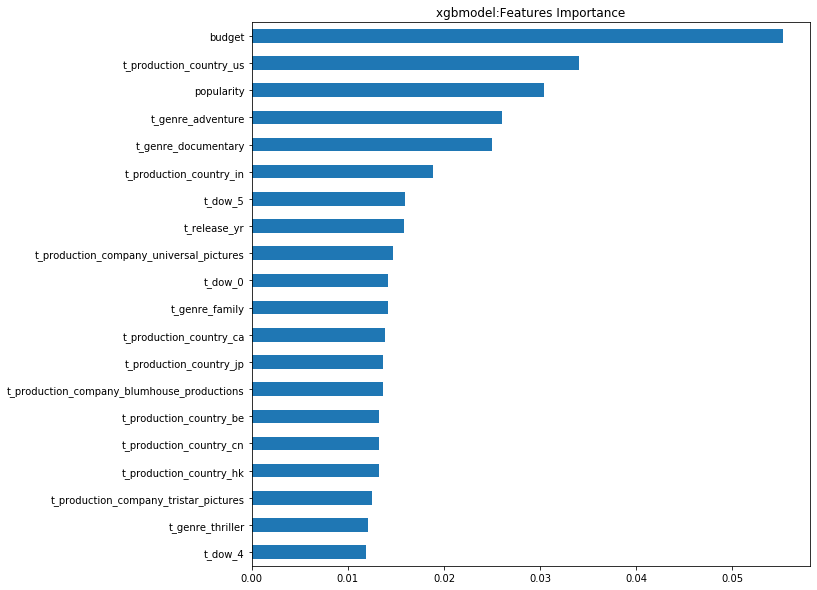

In [14]:
xgbmodel.FI.mean(axis=1).sort_values().tail(20).plot(
    kind="barh",
    title = "xgbmodel:Features Importance",
    figsize = (10,10))

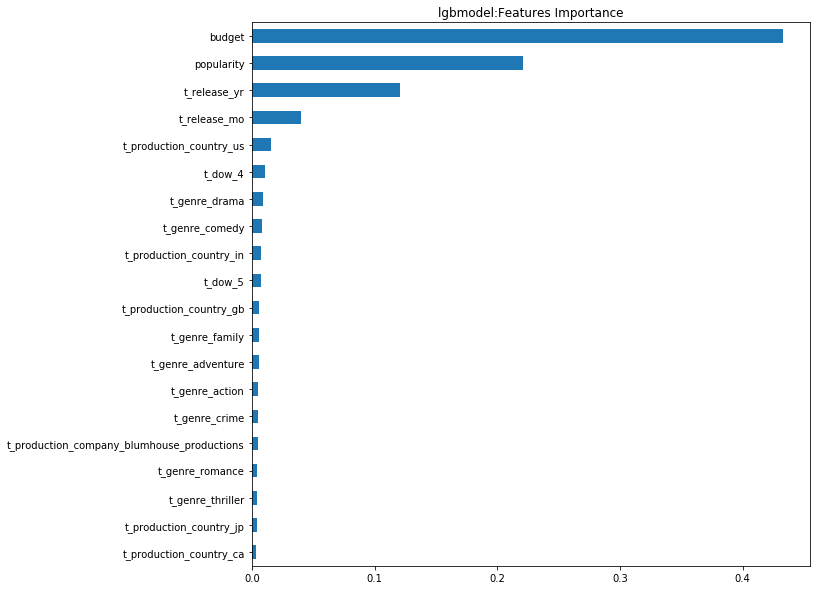

In [15]:
lgbmodel.FI.mean(axis=1).sort_values().tail(20).plot(
    kind="barh",
    title = "lgbmodel:Features Importance",
    figsize = (10,10))

In [16]:
def DotSum(A, B):
    return sum(a*b for a,b in zip(A, B))

train['mix1'] = DotSum((0.4, 0.2, 0.4),
                       (train['xgb'], train['cat'], train['lgb']))
test['mix1'] = DotSum((0.4, 0.2, 0.4),
                      (test['xgb'], test['cat'], test['lgb']))

train['mix2'] = DotSum((0.34, 0.33, 0.33),
                      (train['xgb'], train['cat'], train['lgb']))
test['mix2'] = DotSum((0.34, 0.33, 0.33),
                      (test['xgb'], test['cat'], test['lgb']))

for model_name in ('mix1', 'mix2', 'xgb', 'lgb', 'cat'):
    print("RMSE model {}: {}".format(model_name, Score(GetY(train), train[model_name])))

RMSE model mix1: 2.0730723450196376
RMSE model mix2: 2.0712718024273786
RMSE model xgb: 2.0968172025012217
RMSE model lgb: 2.0862801164276714
RMSE model cat: 2.106759450590605


# Submission

In [17]:
for model_name in ('mix1', 'mix2', 'xgb', 'lgb', 'cat'):
    print("Generating submission for ", model_name)
    test['revenue'] =  np.expm1(test[model_name])
    test[['id','revenue']].to_csv(
        'submissions/{}.csv'.format(model_name),
        index=False)
    print(test[['id','revenue']].head())

Generating submission for  mix1
     id       revenue
0  3001  7.781953e+06
1  3002  1.965336e+06
2  3003  8.688388e+06
3  3004  1.954845e+06
4  3005  1.262625e+06
Generating submission for  mix2
     id       revenue
0  3001  6.109708e+06
1  3002  1.867374e+06
2  3003  7.997909e+06
3  3004  2.160472e+06
4  3005  1.200151e+06
Generating submission for  xgb
     id       revenue
0  3001  9.914769e+06
1  3002  1.511610e+06
2  3003  9.600225e+06
3  3004  1.472374e+06
4  3005  1.031895e+06
Generating submission for  lgb
     id       revenue
0  3001  1.280768e+07
1  3002  2.959844e+06
2  3003  1.013651e+07
3  3004  1.900425e+06
4  3005  1.790779e+06
Generating submission for  cat
     id       revenue
0  3001  1.769850e+06
1  3002  1.464762e+06
2  3003  5.228249e+06
3  3004  3.646056e+06
4  3005  9.397614e+05
